In [3]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random


In [4]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [5]:
#dataset = "../../Datasets_Axionable/ironcar_pics"
#dataset = "../../Pics/cleaned1"
#dataset = "../../Pics/tagged2"
#dataset = "../../Track/OldDataset_balanced"
dataset = "../../Track/Mixed"
#dataset = "../../Balanced"

In [6]:
# load images from both train and test groups
directory = '../../' + dataset
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 19246


In [7]:
images = np.array(images)
images /= 255

In [8]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

In [9]:
labels_speed[42], labels_dir[42]

(array([1, 0], dtype=uint8), array([0, 0, 0, 1, 0], dtype=uint8))

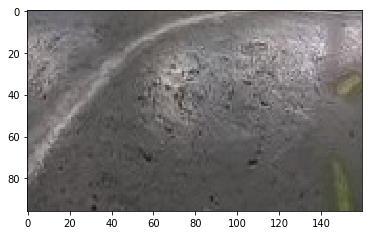

In [10]:
plt.imshow(images[42])

In [11]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [10]:
K.clear_session()
############################################################# Simple Dir Model  

img_in = Input(shape=(96, 160, 3), name='img_in')

x = img_in

x = Convolution2D(8, (16,16), strides=(8,8), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.1)(x)
x = Convolution2D(16, (16,16), strides=(8,8), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.1)(x)
flat = Flatten()(x)
out = Dense(5, activation='softmax')(flat)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 20, 8)         6152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 20, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 12, 20, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 20, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 3, 16)          32784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 3, 16)          64        
__________

In [11]:
h = model.fit(images, labels_dir, batch_size=256, epochs=10, verbose=1, validation_split=0.4)

Train on 10528 samples, validate on 7019 samples
Epoch 1/10
10528/10528 [==============================] - 14s 1ms/step - loss: 0.6819 - acc: 0.7600 - val_loss: 1.0383 - val_acc: 0.5601
Epoch 2/10


KeyboardInterrupt: 

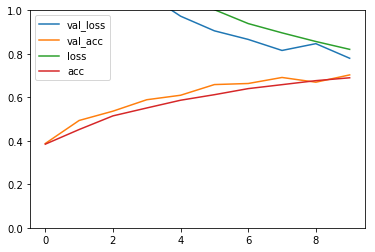

In [12]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [17]:
model.save('model_dir.h5')

In [12]:
K.clear_session()
############################################################# Multitask Model  

img_in = Input(shape=(96, 160, 3), name='img_in')

x = img_in

x = Convolution2D(8, (32,32), strides=(8,8))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(.1)(x)
x = Convolution2D(16, (8,8), strides=(8,8))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(.1)(x)
flat = Flatten()(x)
x = Dense(10, activation='relu')(flat)
x = Dropout(.1)(x)
out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 17, 8)     24584       img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 17, 8)     32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 9, 17, 8)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [34]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 15396 samples, validate on 3850 samples
Epoch 1/10
15396/15396 [==============================] - 33s 2ms/step - loss: 0.0788 - dense_2_loss: 0.0153 - dense_3_loss: 0.0634 - dense_2_acc: 0.9925 - dense_3_acc: 0.9773 - val_loss: 0.8598 - val_dense_2_loss: 0.3957 - val_dense_3_loss: 0.4642 - val_dense_2_acc: 0.9135 - val_dense_3_acc: 0.8605
Epoch 2/10
15396/15396 [==============================] - 39s 3ms/step - loss: 0.0769 - dense_2_loss: 0.0161 - dense_3_loss: 0.0607 - dense_2_acc: 0.9927 - dense_3_acc: 0.9790 - val_loss: 0.4450 - val_dense_2_loss: 0.1517 - val_dense_3_loss: 0.2933 - val_dense_2_acc: 0.9616 - val_dense_3_acc: 0.9281
Epoch 3/10
15396/15396 [==============================] - 38s 2ms/step - loss: 0.0718 - dense_2_loss: 0.0152 - dense_3_loss: 0.0566 - dense_2_acc: 0.9924 - dense_3_acc: 0.9801 - val_loss: 0.6392 - val_dense_2_loss: 0.2387 - val_dense_3_loss: 0.4005 - val_dense_2_acc: 0.9369 - val_dense_3_acc: 0.8901
Epoch 4/10
15396/15396 [========================

KeyboardInterrupt: 

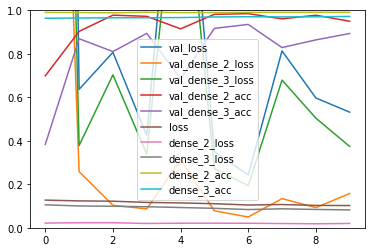

In [20]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [35]:
model.save('model_multi_track.h5')